[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Surrogate Gradient Descent in a Convolutional Spiking Neural Network
## Tutorial 6
### 강의: [Jason K. Eshraghian](https://www.ncg.ucsc.edu)
#### 번역: [ToToKr](https://github.com/MoerAI)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 튜토리얼 시리즈는 다음 문서를 기반으로 합니다. 이러한 리소스나 코드가 작업에 유용하다고 생각되면 다음 소스를 인용해 주세요:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>


# Introduction
이번 튜토리얼에서 당신은:
* 죽은 뉴런 문제(dead neuron problem)을 해결하기 위해 surrogate gradient descent를 수정하는 방법을 배웁니다
* convolutional spiking neural network을 구축하고 훈련합니다
* 순차 컨테이너(sequential container)인 `nn.Sequential`을 사용하여 모델 구성을 간소화 하는 방법을 배웁니다

이 튜토리얼의 일부는 Friedemann Zenke의 SNN에 대한 광범위한 작업에서 영감을 받았습니다. surrogate gradients 대한 [깃허브 레포지토리](https://github.com/fzenke/spytorch)와 제가 즐겨 찾는 논문을 확인하세요: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient
Learning in Spiking Neural Networks: Bringing the Power of
Gradient-based optimization to spiking neural
networks.](https://ieeexplore.ieee.org/document/8891809) IEEE
Signal Processing Magazine 36, 51–63.

튜토리얼의 마지막에는 이미지 분류를 수행하기 위해 MNIST 데이터 세트를 사용하여 convolutional spiking neural network (CSNN) 을 훈련합니다. 배경이론은 [튜토리얼 2, 4, 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에 이어서 설명하므로 복습이 필요한 경우 다시 참조하세요.

Google Colab 실행을 하는 경우:

* 다음 메뉴에서 `런타임` > `런타임 유형 변경` > `하드웨어 가속기: GPU`를 확인하여 GPU를 연결합니다.
* 다음 셀을 클릭하고 `Shift+Enter`를 눌러 최신 PyPi 배포판의 snnTorch를 설치합니다.

In [ ]:
!pip install snntorch

In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

C:\Users\user\AppData\Local\Temp\ipykernel_59436\3569606770.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


# 1. Surrogate Gradient Descent

**죽은 뉴런 문제(dead neuron problem)** 는 [튜토리얼 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 발생합니다. 이것은 스파이크의 미분 불능(non-differentiability)으로 인해 발생합니다:


$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{1}$$
$$\frac{\partial S}{\partial U} = \delta(U - U_{\rm thr}) \in \{0, \infty\} \tag{2}$$

여기서 $\Theta(\cdot)$는 the Heaviside step함수이고 $\delta(\cdot)$는 Dirac-Delta 함수입니다. 이전에는 backward pass에서 임계값으로 시프트된(threshold-shifted) *ArcTangent* 함수의 gradient를 사용하여 이 문제를 해결했습니다.

다른 일반적인 smoothing 함수로는 시그모이드 함수 또는 빠른(fast) 시그모이드 함수가 있습니다. 또한 sigmoidal 함수는 임계값 $U_{\rm thr}$의 중앙에 위치하도록 반드시 시프트 해야합니다. 막 전위의 오버드라이브를 $U_{OD} = U - U_{\rm thr}$로 정의합니다:

$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$

여기서 $k$는 surrogate 함수가 얼마나 smooth한지를 조절하며, 하이퍼파라미터로 취급됩니다. $k$가 증가함에 따라, 근사치는 $(2)$의 원래 도함수에 수렴합니다:  

$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true' width="800">
</center>

요약하자면:

* **Forward Pass**
  - $(1)$에서 시프트된 Heaviside 함수를 사용하여 $S$를 결정합니다
  - 나중에 Backward Pass 중에 사용할 수 있도록 $U$를 저장합니다
* **Backward Pass**
  - $U$를 $(4)$로 전달하여 미분항을 계산합니다

[튜토리얼 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 *ArcTangent* 접근법을 사용한 것과 같은 방식으로 빠른(fast) 시그모이드 함수의 기울기는 Leaky Integrate-and-Fire (LIF) 뉴런 모델에서 Dirac-Delta 함수를 재정의 할 수 있습니다:

In [2]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0, k=25):

      # Leaky_Surrogate is defined in the previous tutorial and not used here
      super(Leaky_Surrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.surrogate_func = self.FastSigmoid.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
    reset = (spk - self.threshold).detach()
    mem = self.beta * mem + input_ - reset
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with gradient of fast sigmoid
  @staticmethod
  class FastSigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mem, k=25):
        ctx.save_for_backward(mem) # store the membrane potential for use in the backward pass
        ctx.k = k
        out = (mem > 0).float() # Heaviside on the forward pass: Eq(1)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (mem,) = ctx.saved_tensors  # retrieve membrane potential
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2  # gradient of fast sigmoid on backward pass: Eq(4)
        return grad, None

더 좋은 방법은, 이모든 것을 snnTorch의 내장 모듈 `snn.surrogate`를 사용하여 간결하게 표현 할 수 있는데, 여기서 $(4)$의 $k$는 `slope`으로 표시됩니다. surrogate gradient는 인자로 `spike_grad`에 전달됩니다:

In [3]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

사용 가능한 다른 surrogate gradient 함수를 살펴보려면, [여기](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html)에서 문서를 참조하세요.

# 2. Setting up the CSNN
## 2.1 DataLoaders

In [4]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2.2 Define the Network

사용되는 CNN 아키텍처는 다음과 같습니다: 12C5-MP2-64C5-MP2-1024FC10

- 12C5는 12개의 필터가 있는 5 $\times$ 5 convolutional 커널입니다.
- MP2는 2 $\times$ 2 max-pooling 함수입니다.
- 1024FC10은 1,024개의 뉴런을 10개의 출력에 매핑하는 fully-connected 레이어입니다.

In [6]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [7]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

이전 튜토리얼 에서는 위 코드와 같이 Network가 Class 안에 선언되었습니다.
네트워크 복잡성이 증가함에 따라 이는 많은 보일러플레이트(boilerplate) 코드(혹은 상용구 코드라고도 불림)를 추가하므로 이를 피하고 싶을 수도 있습니다. 대안으로 `nn.Sequential` 메서드를 대신 사용할 수 있습니다.

> 참고: 다음 코드 블록은 단일 time step에 걸쳐 시뮬레이션하며, 시간이 지남에 따라 별도의 for-loop가 필요합니다.

In [8]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

`init_hidden` 인수는 뉴런의 hidden states(여기서는 막 전위)를 초기화합니다. 이는 인스턴스 변수로 background메서 이루어집니다. `init_hidden`이 활성화되면 막 전위가 사용자에게 명시적으로 반환되지 않으므로 출력 스파이크만 순차적으로 레핑된 레이어를 통해 `nn.Sequential`으로 전달됩니다.

최종 레이어에 막 전위를 사용하여 모델을 훈련하려면 `output=True` 인수를 설정합니다.
이렇게 하면 최종 레이어가 뉴런의 스파이크와 막 전위 반응을 모두 반환할 수 있습니다.

## 2.3 Forward-Pass
시뮬레이션 기간인 `num_steps`에 대한 forward pass는 다음과 같습니다:

In [9]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

이를 함수로 묶어, 시간에 따른 막전위와 스파이크 반응을 기록합니다:

In [11]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [12]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

# 3. Training Loop

## 3.1 Loss Using snn.Functional

이전 튜토리얼에서는 출력 뉴런의 막 전위와 목표 사이의 Cross Entropy Loss를 사용하여 네트워크를 훈련했습니다.

이번에는 Cross Entropy Loss를 사용하는 대신 각 뉴런의 총 스파이크 수를 사용하겠습니다.

다양한 손실 함수가 PyTorch의 `torch.nn.functional`과 유사한 `snn.functional` 모듈에 포함되어 있습니다.
이러한 함수는 Cross Entropy와 Mean square error loss를 구현하며, rate 또는 latency 코딩된 네트워크를 훈련하기 위해 스파이크 및 막 전위에 적용됩니다.

아래 접근 방식은 Rate 코딩 네트워크를 훈련하기 위해 출력 스파이크 수에 교차 엔트로피 손실을 적용합니다:

In [13]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

The recordings of the spike are passed as the first argument to `loss_fn`, and the target neuron index as the second argument to generate a loss. [이 문서에서 자세한 정보와 예제를 제공합니다.](https://snntorch.readthedocs.io/en/latest/snntorch.functional.html#snntorch.functional.ce_rate_loss)

In [14]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


## 3.2 Accuracy Using snn.Functional
`SF.accuracy_rate()`  함수는 예측된 출력 스파이크와 실제 목표 지수를 인자로 제공한다는 점에서 유사하게 작동합니다. `accuracy_rate`는 스파이크 수가 가장 높은 뉴런의 인덱스가 목표 인덱스와 일치하는지 확인하여 출력을 해석하는 데 Rate 코드가 사용된 다고 가정합니다.

In [15]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 12.500%


위의 함수는 단일 데이터 배치의 정확도만 반환하므로, 다음 함수는 전체 데이터로더 객체에 대한 정확도를 반환합니다.

In [16]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [17]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.82%


## 3.3 Training Loop

다음 훈련 loop는 이전 튜토리얼과 질적으로(qualitatively) 유사합니다.

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.81%

Iteration 50, Test Acc: 91.10%

Iteration 100, Test Acc: 95.55%

Iteration 150, Test Acc: 96.70%

Iteration 200, Test Acc: 97.24%

Iteration 250, Test Acc: 96.92%

Iteration 300, Test Acc: 96.96%

Iteration 350, Test Acc: 97.02%

Iteration 400, Test Acc: 97.54%

Iteration 450, Test Acc: 98.01%



상당히 일반적인 네트워크 아키텍처를 선택했음에도 불구하고 짧은 트레이닝을 통해 테스트 세트의 정확도는 상당히 경쟁력이 있습니다!!

# 4. Results
## 4.1 Plot Test Accuracy

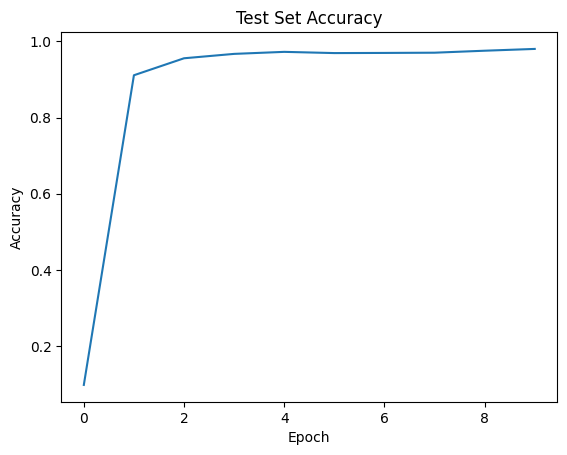

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 4.2 Spike Counter

데이터 batch에 대한 forward pass를 실행하여 스파이크 및 멤브레인 측정값을 얻습니다.

In [21]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

`idx`를 변경하려면 시뮬레이션된 미니배치에서 다양한 샘플로 인덱싱 할 수 있습니다. `splt.spike_count`를 사용해 몇 가지 다른 샘플의 스파이크 동작을 살펴보세요!

> 참고: 데스크톱에서 로컬로 ipynb을 실행하는 경우, 아래 줄의 주석 처리를 해제하고 ffmpeg.exe의 경로를 수정하세요.

The target label is: 1


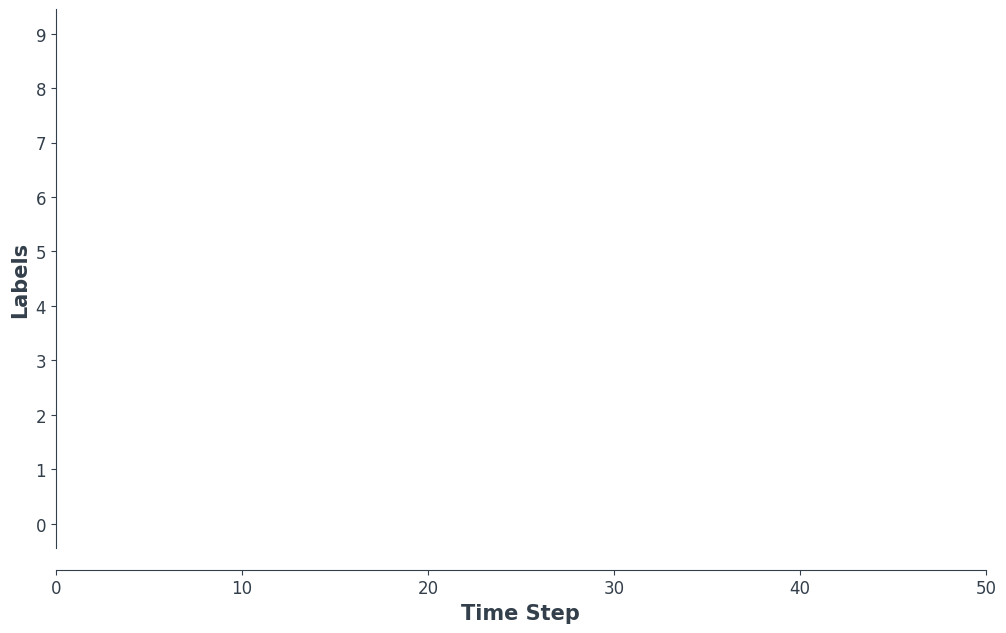

In [23]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Conclusion
이제 snnTorch의 기본 기능을 이해하고 직접 실행 할 수 있을 것입니다. [다음 튜토리얼 에서는](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) neuromorphic dataset을 통하여 학습하는 법을 배웁니다.

또한 튜토리얼에 대한 귀중한 피드백을 제공해 주신 [Gianfrancesco Angelini](https://github.com/gianfa)에게 특별히 감사드립니다.

이 프로젝트가 마음에 드신다면 GitHub에서 리포지토리의 ⭐(Star)를 눌러주세요.

# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)